# Delivery Duration Prediction

## Assignment
When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

- Start: the time consumer submits the order (created_at) to
- End: when the order will be delivered to the consumer (actual_delivery_time)

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime  import datetime

## 1. Load and Explore the Data

In [84]:
data = pd.read_csv('/Users/rosiebai/Downloads/datasets 4/historical_data.csv')

In [85]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [86]:
data.shape

(197428, 16)

In [87]:
# check missing values 
data.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [88]:
data.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [89]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

## 2. Feature Engineering

Create new features that might help your model:
- delivery_duration (target)
- Time of day / day of week / hour from created_at
- Estimate preparation time, delivery distance, or order size if possible
- Categorical encoding: store_id, market_id, order_protocol

In [90]:
# Target Variable 
data['delivery_duration'] = (data.actual_delivery_time - data.created_at).dt.total_seconds()

In [91]:
# timestamp features: created_at, actual_delivery_time
# id features: market_id, store_id
# numeric features: 
#   - order features: total_items, subtotal, min_item_price, max_item_price 
#   - dasher features: total_onshift_dashers, total_busy_dashers, total_outstanding_orders
# delivery features: estimated_order_place_duration, estimated_store_to_consumer_driving_duration
# categorical features: store_primary_category, order_protocol 


In [92]:
data['order_dow'] = data['created_at'].dt.day_of_week
data['order_hour'] = data['created_at'].dt.hour
data['is_weekend'] = np.where(data['order_dow'] >= 5,1,0)

In [93]:
data['estimated_store_to_consumer_driving_duration'].describe()

count    196902.000000
mean        545.358935
std         219.352902
min           0.000000
25%         382.000000
50%         544.000000
75%         702.000000
max        2088.000000
Name: estimated_store_to_consumer_driving_duration, dtype: float64

In [94]:
data['order_hour'].unique()

array([22, 21, 20,  2,  3,  0,  1, 19,  4, 23,  5, 18,  6, 17, 16, 15, 14,
        7,  8], dtype=int32)

In [95]:
data['store_id'].nunique()

6743

In [96]:
data['market_id'].nunique()

6

<AxesSubplot:>

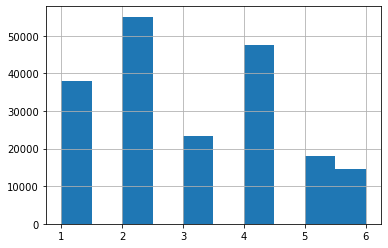

In [113]:
data['market_id'].hist()

In [97]:
data['order_protocol'].nunique()

7

## 3. Data Cleaning

- Handle missing values
- Convert timestamps to datetime
- Drop rows with missing targets

In [98]:
# store_id: an id representing the restaurant the order was submitted for
# store_primary_category: cuisine category of the restaurant, e.g., italian, asian
# store_id is not unique, we can impute cusine category according to the store_ids. 
# I want to:
# 1. Build a mapping dictionary from store_id → store_primary_category using rows that already have a category.
# 2. Use that dictionary to fill in missing store_primary_category values.
# Drop rows where category is missing

mapping_dict = (
    data.dropna(subset = ['store_primary_category'])
        .drop_duplicates(subset = ['store_id'])
        .set_index('store_id')['store_primary_category']
        .to_dict()
)
#mapping_dict

In [99]:
data['store_primary_category'] = data.apply(
    lambda row: mapping_dict.get(row['store_id'], row['store_primary_category']),
    axis = 1
)
data['store_primary_category'].isna().sum()

867

In [100]:
data = data.dropna(subset = ['actual_delivery_time'])
len(data)

197421

In [101]:
data['actual_delivery_time'].isna().sum()

0

## 4. Model Training
- Linear Regression (baseline)


In [102]:
# since there are too many variations in store_id, i wouldn't want to include it into the model.
encoded = pd.get_dummies(data[['market_id','order_protocol']],
                         columns = ['market_id','order_protocol'],
                         prefix = ['market', 'protocol']
                         )
# merge with original dataset
data_encoded = pd.concat([data, encoded], axis = 1)
# drop original columns
data_encoded.drop(['market_id', 'order_protocol'], axis = 1, inplace = True)

In [103]:
data_encoded.columns

Index(['created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration',
       'order_dow', 'order_hour', 'is_weekend', 'market_1.0', 'market_2.0',
       'market_3.0', 'market_4.0', 'market_5.0', 'market_6.0', 'protocol_1.0',
       'protocol_2.0', 'protocol_3.0', 'protocol_4.0', 'protocol_5.0',
       'protocol_6.0', 'protocol_7.0'],
      dtype='object')

In [104]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm

# -----------------------------
# 1) Features / Target
# -----------------------------
features = [
    'total_items',
    'subtotal',
    'min_item_price', 'max_item_price',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration',
    'order_hour', 'order_dow', 'is_weekend'
]
target = 'delivery_duration'  # or 'delivery_duration_seconds'


# Drop missing
df_model = data.dropna(subset=features + [target]).copy()
X = df_model[features]
y = df_model[target]

# -----------------------------
# 2) Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -----------------------------
# 3) Standardize Features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -----------------------------
# 4) scikit-learn: Fit & Evaluate
# -----------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"[sklearn] MAE:  {mae:.2f} seconds")
print(f"[sklearn] RMSE: {rmse:.2f} seconds")

# Coefficients (standardized features)
coef_df = pd.DataFrame({
    'Feature': features,
    'Coef (std-scaled X)': lr.coef_
}).sort_values('Coef (std-scaled X)', key=lambda s: s.abs(), ascending=False)
print(coef_df)

# -----------------------------
# 5) statsmodels: p-values on same (scaled) design
# -----------------------------
# Add constant (intercept)
X_train_sm = sm.add_constant(X_train_scaled, has_constant='add')

# OLS with conventional SE
ols = sm.OLS(y_train, X_train_sm).fit()
print(ols.summary())

# OPTIONAL: Heteroskedasticity-robust standard errors (recommended for durations)
ols_robust = ols.get_robustcov_results(cov_type='HC1')
print(ols_robust.summary())

# Tidy table with p-values and CIs (robust)
results_tbl = pd.DataFrame({
    'term': ['const'] + features,
    'coef': ols_robust.params,
    'std_err': ols_robust.bse,
    't': ols_robust.tvalues,
    'p_value': ols_robust.pvalues,
    'ci_low': ols_robust.conf_int()[:, 0],
    'ci_high': ols_robust.conf_int()[:, 1]
})
print(results_tbl.sort_values('p_value'))


[sklearn] MAE:  970.80 seconds
[sklearn] RMSE: 42917.50 seconds
                                        Feature  Coef (std-scaled X)
5  estimated_store_to_consumer_driving_duration           253.720203
8                                    is_weekend           182.032644
1                                      subtotal           177.377477
7                                     order_dow          -159.695663
6                                    order_hour          -137.262361
4                estimated_order_place_duration           104.709289
0                                   total_items            21.313981
3                                max_item_price            16.808111
2                                min_item_price            -3.477111
                            OLS Regression Results                            
Dep. Variable:      delivery_duration   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:  



## 5. Refinement
- Hyperparameter tuning
- Feature selection
- Error analysis (which deliveries are hardest to predict?)


### Feature selection (adding categorical features)

In [105]:


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 1) Features / Target
# -----------------------------
numeric_features = [
    'total_items',
    'subtotal',
    'min_item_price', 'max_item_price',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration',
    'order_hour', 'order_dow', 'is_weekend'
]

categorical_features = ['market_id', 'order_protocol']

target = 'delivery_duration'  # or 'delivery_duration_seconds'


# Drop rows with missing values in features or target
df_model = data.dropna(subset=numeric_features + categorical_features + [target]).copy()

X = df_model[numeric_features + categorical_features]
y = df_model[target]

# -----------------------------
# 2) Preprocessing pipeline
# -----------------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# -----------------------------
# 3) Full pipeline: preprocess + model
# -----------------------------
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# -----------------------------
# 4) Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -----------------------------
# 5) Fit & Evaluate
# -----------------------------
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = model.score(X_test, y_test)

print(f"MAE:  {mae:.2f} seconds")
print(f"RMSE: {rmse:.2f} seconds")
print(f"R²:   {r2:.4f}")


MAE:  770.98 seconds
RMSE: 1063.07 seconds
R²:   0.1085


After adding the categorical features, the MAE and RMSE both decreased dramtically, so the second model with categorical features is better. However, the R^2 is still very low, I suspect that the relationship between X's and Y here might not be linear, or some X's have a more skewed distribution, in that case, we might need to group rare categories before encoding. Next, I would want to try a non-linear model, like random forest or XGBoost.

### Error Analysis

In [106]:
# Predictions
y_pred = model.predict(X_test)

# Residuals (errors)
errors = y_test - y_pred

# Store in DataFrame for analysis
error_df = X_test.copy()
error_df[target] = y_test
error_df['predicted'] = y_pred
error_df['error'] = errors
error_df['abs_error'] = errors.abs()


In [107]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs(errors / y_test)) * 100

print(f"MAE : {mae:.2f} sec")
print(f"RMSE: {rmse:.2f} sec")
print(f"MAPE: {mape:.2f}%")


MAE : 770.98 sec
RMSE: 1063.07 sec
MAPE: 30.16%


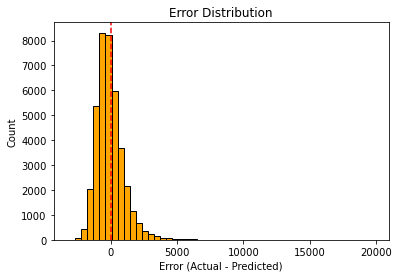

In [108]:
import matplotlib.pyplot as plt

plt.hist(errors, bins=50, color='orange', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Count")
plt.show()


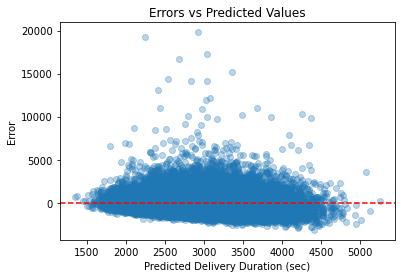

In [109]:
plt.scatter(y_pred, errors, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Errors vs Predicted Values")
plt.xlabel("Predicted Delivery Duration (sec)")
plt.ylabel("Error")
plt.show()


In [110]:
# By day of week
print(error_df.groupby('order_dow')['abs_error'].mean().sort_values(ascending=False))
# We can see that Monday's delivery duration is hard to predict. 
# By hour of day
print(error_df.groupby('order_hour')['abs_error'].mean().sort_values(ascending=False))
# We can see that 2pm, 3pm and 7am are hard to predict.
# By market
print(error_df.groupby('market_id')['abs_error'].mean().sort_values(ascending=False))
# We can see that market_id  = 1 is hard to predict. 
# By order protocol
print(error_df.groupby('order_protocol')['abs_error'].mean().sort_values(ascending=False))
# Order protocol being 6 is hard to predict. 


order_dow
0    893.725297
5    806.796305
6    776.234491
3    765.530948
1    741.375267
2    711.899833
4    681.355803
Name: abs_error, dtype: float64
order_hour
14    1410.630405
15    1092.850205
7     1030.240126
5      901.722866
6      857.693103
0      851.092382
16     848.650575
4      833.644222
17     799.336090
3      784.216218
2      769.893467
1      769.859995
18     759.044037
19     743.975085
23     718.651990
20     698.706494
22     691.886994
21     671.092478
Name: abs_error, dtype: float64
market_id
1.0    997.233266
3.0    793.228713
6.0    756.608123
4.0    724.369929
5.0    713.927378
2.0    671.504215
Name: abs_error, dtype: float64
order_protocol
6.0    941.468863
1.0    848.520876
4.0    845.393300
2.0    762.603101
5.0    726.712434
3.0    705.294485
7.0    529.454282
Name: abs_error, dtype: float64


In [111]:

# Get predictions from your final linear regression model
y_pred = model.predict(X_test)

# Create a DataFrame with actual, predicted, and errors
row_errors = X_test.copy()
row_errors['actual_delivery_duration'] = y_test
row_errors['predicted_delivery_duration'] = y_pred
row_errors['error'] = row_errors['actual_delivery_duration'] - row_errors['predicted_delivery_duration']
row_errors['abs_error'] = row_errors['error'].abs()

# Sort by absolute error (largest mistakes first)
row_errors_sorted = row_errors.sort_values(by='abs_error', ascending=False)

# Show top 20 worst predictions
row_errors_sorted.head(20)


,total_items,subtotal,min_item_price,max_item_price,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,order_hour,order_dow,is_weekend,market_id,order_protocol,actual_delivery_duration,predicted_delivery_duration,error,abs_error
81629,2,1268,539,729,251,579.0,1,0,0,2.0,4.0,22727.0,2928.803599,19798.196401,19798.196401
44254,3,4300,1300,1700,251,194.0,20,4,0,6.0,2.0,21536.0,2242.151385,19293.848615,19293.848615
13460,3,1593,339,549,251,591.0,1,3,0,1.0,5.0,20322.0,3035.828303,17286.171697,17286.171697
137650,2,2490,695,1695,251,154.0,1,5,1,2.0,2.0,19398.0,2678.735656,16719.264344,16719.264344
131426,4,2248,125,999,251,959.0,0,5,1,6.0,5.0,18551.0,3365.999042,15185.000958,15185.000958
193893,3,1100,350,400,251,384.0,17,4,0,1.0,2.0,16943.0,2545.282926,14397.717074,14397.717074
147178,1,400,400,400,251,655.0,0,0,0,6.0,2.0,17034.0,2839.707822,14194.292178,14194.292178
80009,3,4197,799,1599,251,829.0,2,3,0,5.0,3.0,17146.0,3044.033694,14101.966306,14101.966306
34724,2,1628,499,1129,251,636.0,20,2,0,4.0,3.0,15448.0,2412.639961,13035.360039,13035.360039
73757,3,1060,50,741,251,694.0,3,5,1,5.0,4.0,15244.0,3076.912023,12167.087977,12167.087977
